In [1]:
# ORIGINAL RGB FILE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pystan

from IPython.display import display

from matplotlib import rc
rc("font", family="serif", size=11)

In [2]:
output = pd.read_csv('../data/output_1000stars.csv', usecols=range(1,4))
#IDs = [(output.loc[output['ID'] == random.choice(output['ID'])]).iloc[0]['Numax'] for i in range(5)]

noStars = 10
# Select a random sample of stars from the file, recording their IDs
IDs = [random.choice(output['ID']) for i in range(noStars)]
# Create a list of the numax values corresponding to each ID
Numax = [(output.loc[(output['ID'] == IDs[i])]).iloc[0]['Numax'] for i in range(len(IDs))]
Numax_err = [(output.loc[(output['ID'] == IDs[i])]).iloc[0]['Numax_err'] for i in range(len(IDs))]

print(IDs)

[10087394, 9941141, 9767332, 9596639, 11250139, 11191557, 11559818, 6104786, 11305250, 6188215]


<IPython.core.display.Javascript object>


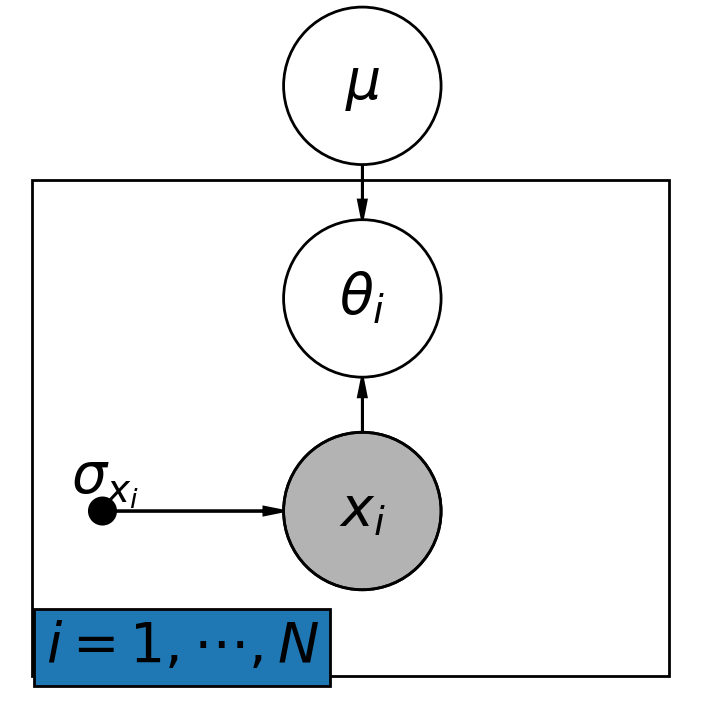

In [31]:
%matplotlib notebook
from matplotlib import rc
rc("font", family="serif", size=20)
import daft
pgm = daft.PGM([3,3], grid_unit=3, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("mu", r"$\mu$", 1.5, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("theta", r"$\theta_{i}$", 1.5, 1.7))
# Data.
pgm.add_node(daft.Node("x", r"$x_{i}$", 1.5, 0.8, observed=True))
pgm.add_node(daft.Node("xerr", r"$\sigma_{x_{i}}$", 0.4, 0.8, fixed=True, offset=[0.7,0.7]))
# Add in the edges.
pgm.add_edge("mu", "theta")
pgm.add_edge("x", "theta")
pgm.add_edge("xerr", "x")
# And a plate.
pgm.add_plate(daft.Plate([0.1, 0.2, 2.7, 2.0], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

In [ ]:
%matplotlib notebook
from matplotlib import rc
rc("font", family="serif", size=20)
import daft
pgm = daft.PGM([3,3], grid_unit=3, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("mu", r"$\mu$", 1.5, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("theta", r"$\theta_{i}$", 1.5, 1.7))
# Data.
pgm.add_node(daft.Node("x", r"$x_{i}$", 1.5, 0.8, observed=True))
pgm.add_node(daft.Node("xerr", r"$\sigma_{x_{i}}$", 0.4, 0.8, fixed=True, offset=[0.7,0.7]))
# Add in the edges.
pgm.add_edge("mu", "theta")
pgm.add_edge("x", "theta")
pgm.add_edge("xerr", "x")
# And a plate.
pgm.add_plate(daft.Plate([0.1, 0.2, 2.7, 2.0], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

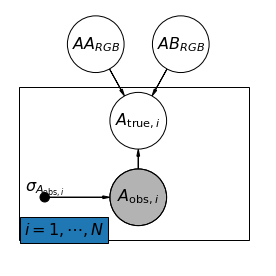

In [3]:
from matplotlib import rc
rc("font", family="serif", size=16)
import daft
pgm = daft.PGM([3,3], grid_unit=3, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("AA", r"$AA_{RGB}$", 1.0, 2.6))
pgm.add_node(daft.Node("AB", r"$AB_{RGB}$", 2.0, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("A_true", r"$A_{{\rm true},i}$", 1.5, 1.7))
# Data.
pgm.add_node(daft.Node("A_obs", r"$A_{{\rm obs},i}$", 1.5, 0.8, observed=True))
pgm.add_node(daft.Node("Aerr", r"$\sigma_{A_{{\rm obs},i}}$", 0.4, 0.8, fixed=True, offset=[0.0,0.4]))
# Add in the edges.
pgm.add_edge("AA", "A_true")
pgm.add_edge("AB", "A_true")
pgm.add_edge("A_obs", "A_true")
pgm.add_edge("Aerr", "A_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.1, 0.4, 2.7, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

In [4]:
modesID = [pd.read_csv('../data/rgbmodes/modes_'+str(IDs[i])+'.csv', usecols=['f0', 'f0_err', 'A0'])
           for i in np.arange(0,len(IDs),1)]
lenmodes = [len(modesID[i]) for i in range(len(IDs))]
maxmodes = max(lenmodes)
arr_n = np.zeros([len(IDs),maxmodes])
arr_freq = np.zeros([len(IDs),maxmodes])
arr_freqerr = np.zeros([len(IDs),maxmodes])


dnu_avgID = []
for i in np.arange(0,len(IDs),1):
    modesID[i] = modesID[i].sort_values(by=['f0'])
    modesID[i] = modesID[i].set_index(np.arange(0,len(modesID[i]),1))
    modesID[i]['dnu'] = (modesID[i]['f0'].diff(2).shift(-1))/2
    dnu_avg = (np.mean(modesID[i]['dnu']))
    dnu_avgID.append(dnu_avg)
    
    n_min = int(modesID[i]['f0'].min() / dnu_avg)
    n = np.arange(n_min, n_min+len(modesID[i]), 1)
    modesID[i].insert(loc=0, column='n', value=n)
    
    # Loop to ensure all arrays are the same length
    if lenmodes[i] < maxmodes:
        l = lenmodes[i]
        while l < maxmodes:
            newrow = {'n': int(np.max(modesID[i]['n'])+1),
                      'f0': np.max(modesID[i]['f0'])+dnu_avgID[i],
                      'f0_err': 100000}
            modesID[i] = modesID[i].append(newrow, ignore_index=True)
            #modesID[i].loc[l] = [l, int(np.max(modesID[i]['n']+l)), (np.max(modesID[i]['dnu'])+dnu_avgID[i]), np.nan , 10000]
            #app = pd.DataFrame([(np.max(modesID[i]['dnu'])+dnu_avgID[i]), 10000], columns=['n', 'f0', 'f0_err'])
            #modesID[i].append(app, ignore_index=True)
            l += 1
        
    arr_n[i,:] = modesID[i]['n']
    arr_freq[i,:] = modesID[i]['f0']
    arr_freqerr[i,:] = modesID[i]['f0_err']
    
    #display(modesID[i])
dnu_avgarr = np.asarray(dnu_avgID)

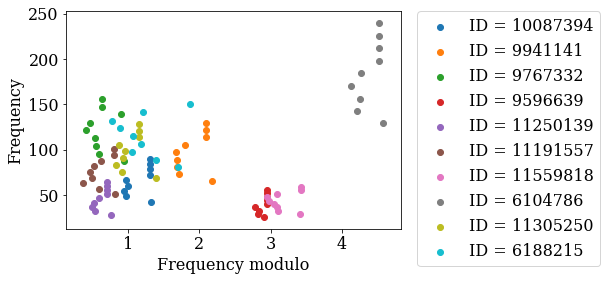

In [5]:
for i in np.arange(0,len(IDs),1):
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))

#Define start parameters
eps = []
for i in range(len(IDs)):
    epsilon1 = np.median((modesID[i].f0 % dnu_avg) / dnu_avg)
    eps.append(epsilon1)
epsilon = np.asarray(eps)

numax_obs = Numax
nmax = numax_obs/dnu_avgarr - epsilon
alpha = 0.015*dnu_avgarr**(-0.32)
A = 0.06*dnu_avgarr**(-0.88) 
G = np.ones([len(IDs)])*3.08
tau = np.ones([len(IDs)])*10
phi = np.ones([len(IDs)])*1.71

plt.ylabel('Frequency')
plt.xlabel(r'Frequency modulo')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [6]:
code = '''
data {
    int N;  //number of stars
    int M; //number of modes
    real n[N, M];
    real freq[N, M];
    real freq_err[N, M];
    real dnu_guess[N];
    real nmax_guess[N];
}
parameters {
    real dnu[N];
    real nmax[N];
    real epsilon[N];
    real alpha[N];
    real<lower = 0> A[N];
    real<lower = 0> G[N];
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi[N];
    real<lower = 0> tau[N];
    real epsA;
    real epsB;
    real alA;
    real alB;
    real AA;
    real AB;
    
}
model {
    real mod[M];
    for (i in 1:N){
        for (j in 1:M){
            mod[j] = (n[i,j] + epsilon[i] + (alpha[i]/2) * (nmax[i] - n[i,j])^2 + 
                A[i]*G[i]/(2*pi()) * sin((2*pi()*(n[i,j]-nmax[i]))/G[i] + phi[i]))*dnu[i];
                //*exp(-n[i,j]/tau[i]);
            mod[j] ~ normal(freq[i], freq_err[i]);
        }
        nmax[i] ~ normal(nmax_guess[i], nmax_guess[i]*0.1);
        dnu[i] ~ normal(dnu_guess[i], dnu_guess[i]*0.01);
        epsilon[i] ~ normal(epsA + epsB*log(dnu[i]), 0.5);
        alpha[i] ~ lognormal(log(alA*dnu[i]^(-alB)), 0.3);
        A[i] ~ lognormal(log(AA*dnu[i]^(-AB)), 0.4);
        //epsilon[i] ~ uniform(-1.0, 2.0);
        //alpha[i] ~ lognormal(log(0.015*dnu[i]^(-0.32)), 0.5);
        //A[i] ~ lognormal(log(0.06*dnu[i]^(-0.88)), 0.6);
    }
    nmax ~ normal(10, 4);
    G ~ normal(3.08, 0.65);
    tau ~ normal(20, 10);
    epsA ~ normal(0.601, 0.08);
    epsB ~ normal(0.632, 0.08);
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08);
    AA ~ normal(0.06, 0.01);
    AB ~ normal(0.88, 0.05);
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ea1f1dcb5b4f091dc3b628af19cb03a3 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmp786l3zg5/stanfit4anon_model_ea1f1dcb5b4f091dc3b628af19cb03a3_6486327874378546150.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [7]:
stan_data = {'N': len(IDs),
         'M': maxmodes,
         'n': arr_n, 
         'freq': arr_freq,
         'freq_err': arr_freqerr,
         'dnu_guess': dnu_avgarr,
         'nmax_guess': nmax
        }
start = {'dnu': dnu_avgarr,
         'nmax': nmax,
         'epsilon': epsilon,
         'alpha': alpha,
         'A': A,
         'G': G,
         'tau': tau,
         'phi': phi,
         'epsA': 0.601,
         'epsB': 0.632,
         'alA': 0.015,
         'alB': 0.32,
         'AA': 0.06,
         'AB': 0.88
    }
nchains = 4

fit = sm.sampling(data=stan_data, iter=20000, chains=nchains, init=[start for n in range(nchains)])

In [8]:
print(fit)

Inference for Stan model: anon_model_ea1f1dcb5b4f091dc3b628af19cb03a3.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu[1]        4.48    0.13   0.32   3.79   4.31   4.52   4.65   5.09      6   1.87
dnu[2]         5.3    0.49   1.08   3.31    4.4   5.33   6.31   6.67      5   2.44
dnu[3]        6.72     0.2    0.5    5.7   6.44   6.75   6.93   7.97      6   1.85
dnu[4]        3.35    0.14   0.33    2.7   3.08   3.39   3.66   3.74      6   2.57
dnu[5]        3.41    0.07   0.19   3.02   3.32   3.42   3.49   3.72      8   1.57
dnu[6]        5.53    0.13   0.33   5.23   5.28   5.31   5.78    6.2      6   1.77
dnu[7]        3.44    0.08    0.2   3.13   3.25   3.43   3.63    3.7      6   2.38
dnu[8]        6.08    1.41    2.9   2.62   3.73   4.97   8.36  11.78      4   2.17
dnu[9]        6.73    0.15   0.37   6.35   6.43   6.48   7.0

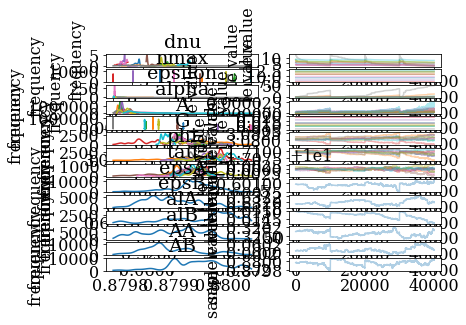

In [9]:
fit.plot()
plt.show()

In [10]:
def model(n, dnu, nmax, epsilon, alpha, A, G, phi, tau):
    freqs = (n + epsilon + (alpha/2) * (n - nmax)**2 + ((A*G)/(2*np.pi)) * np.sin((2*np.pi*(n-nmax))/G + phi)) * dnu# * np.exp(-n/tau)
    return freqs

In [11]:
#for i in range(len(IDs)):
    #print(np.mean(modesID[i]['dnu']))

#for i in range(len(IDs)):
    #print(np.mean(fit['G'], axis=0)[i])

[42.82949557 48.41536046 54.31322765 60.29777173 66.20911982 72.47619861
 78.40625641 84.33631421 90.26637201]
[36.95685921 41.44136407 45.9625994  50.40393441 54.88075776 59.40543605
 63.85140626 68.32066305 72.84760793]
[ 65.82999266  73.31645537  81.25068442  89.20472862  97.14046153
 105.22889296 113.47692054 121.43285709 129.38879364]
[ 66.34121532  71.60537708  76.94122543  82.25725151  87.51950763
  92.85014344  98.17285575 103.4343653  108.75906455]
[ 87.2848518   95.57092719 104.16894645 112.7903092  121.29145262
 129.98036518 139.04883939 147.41800077 156.05225586]
[ 77.94110697  84.67372061  91.4317221   98.10486411 104.82935213
 111.59231968 118.26919105 124.98543459 131.75221731]
[25.42958182 29.09422025 32.86262781 36.56284945 40.47667006 44.22928964
 47.98190921 51.73452878 55.48714836]
[21.61308951 25.01000828 28.32385221 31.64624325 35.04400627 38.36502335
 41.68018065 45.07742347 48.40624953]
[28.18314556 32.52222842 37.05370361 41.64798552 46.28807995 50.97124027
 55

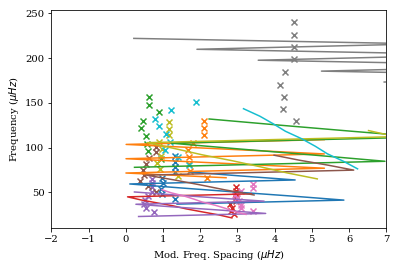

In [12]:
%matplotlib inline
for i in range(len(IDs)):
    plt.figure(len(IDs))
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], marker='x', label=r'$l=$'+str(0))
    #plt.errorbar(modesID[i]['f0'] % np.mean(modesID[i]['dnu']), modesID[i]['f0'], xerr=modesID[i]['f0_err'], zorder=0, fmt="none", label="none",
             #c='k', capsize=2, markersize=4, elinewidth=1)
    #np.mean(modesID[i]['dnu'])
    g2 = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['nmax'],axis=0)[i], np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
          np.mean(fit['A'], axis=0)[i], np.mean(fit['G'], axis=0)[i], np.mean(fit['phi'], axis=0)[i], 33) #np.mean(fit['tau'], axis=0)[i])
    plt.plot(g2 % dnu_avgID[i], g2, label='Fit_2D')
    print(arr_freq[i])
    print(g2)

plt.ylabel('Frequency ($\mu Hz$)')
plt.xlabel(f'Mod. Freq. Spacing ($\mu Hz$)')
plt.xlim(-2,7)
plt.show()



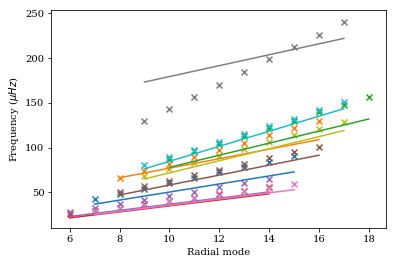

In [13]:
for i in range(len(IDs)):
    plt.figure(len(IDs))
    plt.scatter(modesID[i]['n'], modesID[i]['f0'], marker='x', label=r'$l=$'+str(0))
    #plt.errorbar(modesID[i]['f0'] % np.mean(modesID[i]['dnu']), modesID[i]['f0'], xerr=modesID[i]['f0_err'], zorder=0, fmt="none", label="none",
             #c='k', capsize=2, markersize=4, elinewidth=1)
    #np.mean(modesID[i]['dnu'])
    g2 = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['nmax'],axis=0)[i], np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
          np.mean(fit['A'], axis=0)[i], np.mean(fit['G'], axis=0)[i], np.mean(fit['phi'], axis=0)[i], 33) #np.mean(fit['tau'], axis=0)[i])
    plt.plot(arr_n[i], g2, label='Fit_2D')

plt.ylabel('Frequency ($\mu Hz$)')
plt.xlabel(f'Radial mode')
plt.show()

Text(0.5, 0.98, 'Parameters plotted against $\\langle \\Delta \\nu \\rangle$')

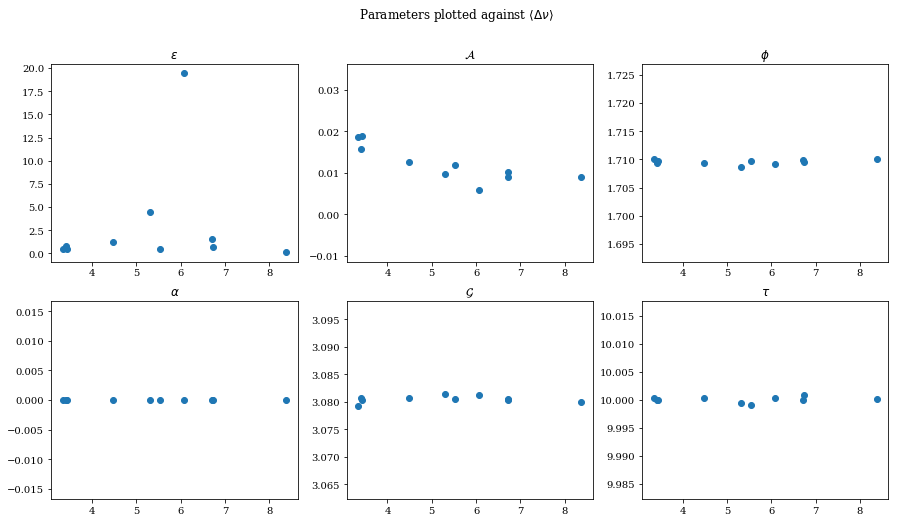

In [14]:
dnus = []
epsilons = []
alphas = []
As = []
Gs = []
phis = []
taus = []
for i in range(len(IDs)):
    dnus.append(np.mean(fit['dnu'],axis=0)[i])
    epsilons.append(np.mean(fit['epsilon'],axis=0)[i])
    alphas.append(np.mean(fit['alpha'],axis=0)[i])
    As.append(np.mean(fit['A'],axis=0)[i])
    Gs.append(np.mean(fit['G'],axis=0)[i])
    phis.append(np.mean(fit['phi'],axis=0)[i])
    taus.append(np.mean(fit['tau'],axis=0)[i])
    
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharey=False, sharex=False)
axs[0,0].scatter(dnus, epsilons)
axs[0,0].set_title(r'$\epsilon$')
axs[1,0].scatter(dnus, alphas)
axs[1,0].set_title(r'$\alpha$')
axs[0,1].scatter(dnus, As)
axs[0,1].set_title(r'$\mathcal{A}$')
axs[1,1].scatter(dnus, Gs)
axs[1,1].set_title(r'$\mathcal{G}$')
axs[0,2].scatter(dnus, phis)
axs[0,2].set_title(r'$\phi$')
axs[1,2].scatter(dnus, taus)
axs[1,2].set_title(r'$\tau$')
fig.suptitle(r'Parameters plotted against $\langle \Delta \nu \rangle$')

In [15]:
import corner
data = np.vstack([fit['epsilon'], fit['alpha'], fit['dnu'], fit['nmax'],
                  fit['a'], fit['omega'], fit['phi'], fit['tau']]).T
corner.corner(data, labels=[r'$\epsilon$', r'$k$',r'$\Delta\nu$',r'$n_{max}$',
                            r'$A$', r'$\omega$', r'$\phi$', r'$\tau$'])
              #, truths=[1.436, 0.07, 0.3, 2, 0])
plt.show()

ValueError: No parameter a